In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.covariance import EllipticEnvelope
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
%matplotlib notebook

In [2]:
df = pd.read_csv('openpowerlifting-2020-03-31.csv', dtype={'ParentFederation': 'object', 'MeetState': 'object'})
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Glossbrenner,IPFPoints,Tested,Country,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetName
0,Tucker Sanders,M,B,Single-ply,15.0,13-15,14-18,Teen 14-15,52.0,52,...,82.14,489.70,NaN,USA,USABPA,NaN,2019-04-06,USA,TX,Ronnie Coleman Classic
1,Xander Womack,M,B,Single-ply,14.0,13-15,14-18,Teen 14-15,100.0,100,...,94.46,474.29,NaN,USA,USABPA,NaN,2019-04-06,USA,TX,Ronnie Coleman Classic
2,Michael Womack III,M,B,Single-ply,16.0,16-17,NaN,Teen 16-17,67.5,67.5,...,82.33,464.78,NaN,USA,USABPA,NaN,2019-04-06,USA,TX,Ronnie Coleman Classic
3,Logan McCurley,M,B,Single-ply,16.0,16-17,14-18,Teen 16-17,75.0,75,...,80.90,451.47,NaN,USA,USABPA,NaN,2019-04-06,USA,TX,Ronnie Coleman Classic
4,Emily Jondron,F,B,Single-ply,21.0,20-23,NaN,Juniors 20-25,90.0,90,...,120.17,671.39,NaN,USA,USABPA,NaN,2019-04-06,USA,TX,Ronnie Coleman Classic


# Data Exploration and Cleaning

In [24]:
df['Event'].unique()

array(['B', 'SBD', 'D', 'BD', 'S', 'SB', 'SD'], dtype=object)

In [25]:
(df.groupby('Event')[['Best3BenchKg', 'Best3SquatKg', 'Best3DeadliftKg']]).mean()

,Best3BenchKg,Best3SquatKg,Best3DeadliftKg
Event,,,
B,146.916065,NaN,NaN
BD,118.659589,NaN,190.458802
D,NaN,NaN,203.377088
S,NaN,179.098637,NaN
SB,102.795525,163.543734,NaN
SBD,109.912268,174.511153,187.569133
SD,NaN,145.114217,158.056743


Event is a categorical column indicating which exercises have been performed on that meeting.
Since I'm interested in correlations between squat, benchpress and deadlift performances, I only use rows with type 'SBD' here (SBD = Squat-Benchpress-Deadlift).

In [5]:
df = df[df['Event'] == 'SBD']
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Glossbrenner,IPFPoints,Tested,Country,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetName
10,Justin Johnson,M,SBD,Wraps,NaN,NaN,NaN,Open,67.5,67.5,...,293.65,424.18,NaN,USA,USSports,NaN,2013-04-13,USA,KS,Kansas State Powerlifting Championships
11,Clint Samuels,M,SBD,Wraps,27.5,24-34,24-39,Open,82.5,82.5,...,375.71,579.47,NaN,NaN,USSports,NaN,2013-04-13,USA,KS,Kansas State Powerlifting Championships
12,Zach Lerner,M,SBD,Wraps,32.5,24-34,24-39,Open,82.5,82.5,...,328.92,496.75,NaN,NaN,USSports,NaN,2013-04-13,USA,KS,Kansas State Powerlifting Championships
13,Jason Steuber,M,SBD,Wraps,NaN,NaN,NaN,Open,90.0,90,...,313.60,470.11,NaN,NaN,USSports,NaN,2013-04-13,USA,KS,Kansas State Powerlifting Championships
14,Michael Schaffer,M,SBD,Wraps,NaN,NaN,NaN,Open,90.0,90,...,265.04,384.18,NaN,USA,USSports,NaN,2013-04-13,USA,KS,Kansas State Powerlifting Championships


In [4]:
noAge = df['Age'].isnull().sum()
print('{} rows without an age value, that is {}% of the data set'.format(noAge, noAge/df.shape[0]))

714702 rows without an age value, that is 0.5257798395960327% of the data set


There are 714702 rows without a value for Age. That's over 50% of all rows!
However there are two more columns 'AgeClass' and 'BirthYearClass', which are related to the athlete's age.

In [5]:
df['BirthYearClass'].value_counts()

24-39     237136
19-23     138350
14-18      98912
40-49      72244
50-59      34169
60-69      13234
70-999      4323
Name: BirthYearClass, dtype: int64

In [6]:
df['AgeClass'].value_counts()

24-34     220257
18-19     139800
20-23     136464
16-17      96361
35-39      52253
40-44      48731
45-49      32764
13-15      25615
50-54      24175
55-59      14112
60-64       9252
65-69       5139
70-74       3050
5-12        2318
75-79       1152
80-999       330
Name: AgeClass, dtype: int64

Both columns represent age intervals, which are reasonably small, so it could be sufficient to simply use the intervals mean when no age is specified.
Since the intervals of the age-classes are slightly smaller then the birth-year-classes, I start using the age-classes to fill the age column. This will give us additional 167293 rows of data (about 12% of the original data set), so it should be worth the effort.

In [7]:
print(np.sum(np.logical_and(df['Age'].isna(), df['AgeClass'].notna())))
print(np.sum(np.logical_and(df['Age'].isna(), df['AgeClass'].notna())) / df.shape[0])

167293
0.1230712754484234


In [6]:
def estimateAge(AgeClass):
    """ Returns an estimated age based on the given age-class
        Args: AgeClass - str consisting of lower and upper bound of the age class, splitted by '-'
        Return: Estimated age - (euclidian mean between lower and upper bound) """
    
    if pd.isnull(AgeClass):
        return np.nan
    else:
        [lowerBound, upperBound] = AgeClass.split('-')
        estimatedAge = (float(upperBound)+float(lowerBound))/2
        estimatedAge = min(estimatedAge, 85) # Limit to 85 for the highest AgeClass (80-999)

        return estimatedAge

## Quick test
#for AgeClass in df['AgeClass'].unique():
#    print(AgeClass)
#    print(estimateAge(AgeClass))

print('Before estimation: '+str(df['Age'].isnull().sum())+' missing age values')

# Create new column for ages estimated by age class
df.loc[:, 'EstimatedAge'] = df['AgeClass'].apply(estimateAge)
# Merge new values into the age column
idx_useEstimatedAge = np.logical_and(df['Age'].isnull(), df['AgeClass'].notna())
df.loc[idx_useEstimatedAge, 'Age'] = df.loc[idx_useEstimatedAge, 'EstimatedAge']

print('After estimation: '+str(df['Age'].isnull().sum())+' missing age values')

Before estimation: 714702 missing age values
After estimation: 547409 missing age values


Some additional values of age data can be squeezed out of the birth-year-class:

In [9]:
print(np.sum(np.logical_and(df['Age'].isna(), df['BirthYearClass'].notna())))

5421


In [7]:
print('Before estimation: '+str(df['Age'].isnull().sum())+' missing age values')

# Create new column for ages estimated by birth-year-class
df.loc[:, 'EstimatedAge'] = df['BirthYearClass'].apply(estimateAge)
# Merge new values into the age column
idx_useEstimatedAge = np.logical_and(df['Age'].isnull(), df['BirthYearClass'].notna())
df.loc[idx_useEstimatedAge, 'Age'] = df.loc[idx_useEstimatedAge, 'EstimatedAge']

print('After estimation: '+str(df['Age'].isnull().sum())+' missing age values')

Before estimation: 547409 missing age values
After estimation: 541988 missing age values


In [8]:
print(df.shape)
df = df.loc[~df[['Sex', 'Age', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']].isnull().any(axis=1)]
print(df.shape)

df_raw = df.copy()
df = df[['Sex', 'Age', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']]

(1359318, 40)
(761756, 40)


In some cases the Best3\*Kg columns have negative values, which is an indicator for failing to perform a regular repetition of the exercise. I'm going to drop these rows.

In [65]:
for column in ['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']:
    df = df[df[column] > 0]
df.shape

(760303, 6)

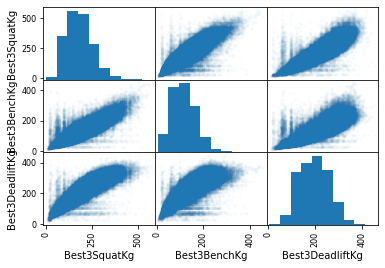

In [36]:
pd.plotting.scatter_matrix(df[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']], alpha=0.02)
plt.show()

In [9]:
cov = EllipticEnvelope(random_state=42, contamination=0.02).fit(df[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']])

In [10]:
maskOutliers = cov.predict(df_raw[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']])
df_clean = df_raw.copy()
print(df_clean.shape)
outliers = pd.Series(maskOutliers, index=df_clean.index)
df_clean = df_clean.loc[outliers==1,:]
print(df_clean.shape)

(761756, 40)
(746520, 40)


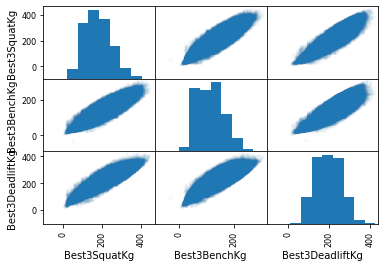

In [69]:
pd.plotting.scatter_matrix(df_clean[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']], alpha=0.02)
plt.show()

In [11]:
df_norm = df_clean.copy()
df_norm.loc[:,'Squat'] = df_norm.loc[:, 'Best3SquatKg']/df_norm.loc[:, 'TotalKg']*3
df_norm.loc[:, 'Bench'] = df_norm.loc[:, 'Best3BenchKg']/df_norm.loc[:, 'TotalKg']*3
df_norm.loc[:, 'Deadlift'] = df_norm.loc[:, 'Best3DeadliftKg']/df_norm.loc[:, 'TotalKg']*3
df_norm = df_norm[['Sex', 'Equipment', 'Age', 'BodyweightKg', 'Squat', 'Bench', 'Deadlift']]
df_norm.head()

,Sex,Equipment,Age,BodyweightKg,Squat,Bench,Deadlift
11,M,Wraps,27.5,82.5,1.003860,0.712080,1.284060
12,M,Wraps,32.5,82.5,1.079974,0.653334,1.266691
17,M,Wraps,24.0,110.0,1.123888,0.637155,1.238918
19,M,Wraps,38.5,110.0,1.090927,0.818195,1.090927
30,F,Wraps,27.0,75.0,1.196110,0.568617,1.235274


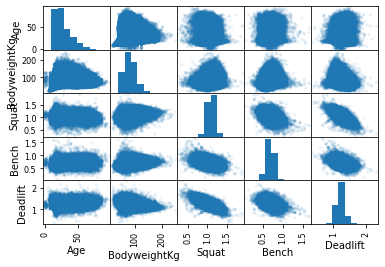

In [71]:
pd.plotting.scatter_matrix(df_norm, alpha=0.1)
plt.show()

In [15]:
print(df_norm['Bench'][df_norm['Sex']=='M'].mean())
print(df_norm['Bench'][df_norm['Sex']=='F'].mean())
print(df_norm['Squat'][df_norm['Sex']=='M'].mean())
print(df_norm['Squat'][df_norm['Sex']=='F'].mean())
print(df_norm['Deadlift'][df_norm['Sex']=='M'].mean())
print(df_norm['Deadlift'][df_norm['Sex']=='F'].mean())

0.7140619581793846
0.6120327288083902
1.0922040036813923
1.1132717968512547
1.1937375503611631
1.2747013662267381


In [12]:
import math
fac = math.sqrt(2)
df_norm.loc[:, 'x1'] = df_norm.loc[:,'Squat'] - df_norm.loc[:, 'Bench']/fac - df_norm.loc[:, 'Deadlift']/fac
df_norm.loc[:, 'x2'] = df_norm.loc[:, 'Bench']/fac - df_norm.loc[:, 'Deadlift']/fac
df_norm.loc[:, 'x1'] = df_norm.loc[:, 'x1'] - df_norm.loc[:, 'x1'].mean()
df_norm.loc[:, 'x2'] = df_norm.loc[:, 'x2'] - df_norm.loc[:, 'x2'].mean()
df_norm[['Squat', 'Bench', 'Deadlift', 'x1', 'x2']].head()

,Squat,Bench,Deadlift,x1,x2
11,1.003860,0.712080,1.284060,-0.161398,-0.027169
12,1.079974,0.653334,1.266691,-0.031464,-0.056427
17,1.123888,0.637155,1.238918,0.043529,-0.048230
19,1.090927,0.818195,1.090927,-0.012801,0.184431
30,1.196110,0.568617,1.235274,0.166792,-0.094116


<IPython.core.display.Javascript object>


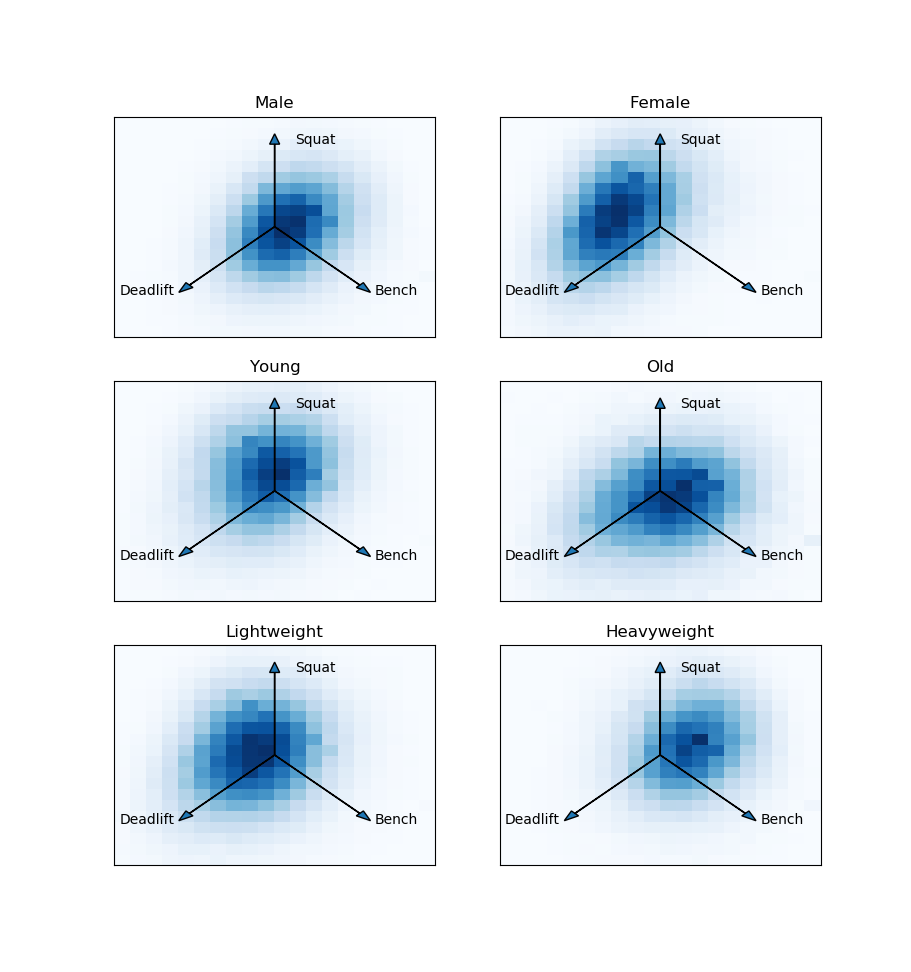

In [18]:
%matplotlib notebook
%matplotlib notebook

bins = 20
plotrange = [[-.4, .4],[-.4, .4]]
cmap = plt.get_cmap('Blues')

def draw_arrows(ax):
    """ Draws arrows for three-dimensional coordinates """
    ax.arrow(0,0,0,0.3,head_width=0.025)
    ax.arrow(0,0,0.3/fac,-0.3/fac,head_width=0.025)
    ax.arrow(0,0,-0.3/fac,-0.3/fac,head_width=0.025)
    ax.text(0.05, 0.3, 'Squat')
    ax.text(0.25, -0.25, 'Bench')
    ax.text(-0.25, -0.25, 'Deadlift', horizontalalignment='right')

def plotSBDhist(ax, df, idx_mask, title):
    """Plots 2D histogram for Squat-Bench-Deadlift-Data filtered by idx_mask
    Args:
        - ax: matplotlib axis
        - df: Dataframe with columns 'x1' and 'x2'
        - idx_mask: True/False filtering array
        - title: Title printed above the plot
    Returns: nothing """
    ax.hist2d(df['x2'][idx_mask], df['x1'][idx_mask], bins=bins, range=plotrange, cmap=cmap)
    draw_arrows(ax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])  

fig = plt.figure()
[[ax1, ax2],[ax3, ax4], [ax5, ax6]] = fig.subplots(nrows=3, ncols=2)

plotSBDhist(ax1, df_norm, df_norm['Sex'] == 'M', 'Male')
plotSBDhist(ax2, df_norm, df_norm['Sex'] == 'F', 'Female')
plotSBDhist(ax3, df_norm, df_norm['Age'] < 20, 'Young')
plotSBDhist(ax4, df_norm, df_norm['Age'] > 40, 'Old')
plotSBDhist(ax5, df_norm, df_norm['BodyweightKg'] < 80, 'Lightweight')
plotSBDhist(ax6, df_norm, df_norm['BodyweightKg'] > 100, 'Heavyweight')

plt.show()

# Training a linear regression model

In [76]:
df_max = df_clean[['Sex', 'Age', 'BodyweightKg', 'Equipment', 'TotalKg']]
df_max = df_max.dropna()

In [37]:
# Add Age**2, Age**3
df_max.loc[:, 'Age2'] = df_max.loc[:,'Age']**2
df_max.loc[:, 'Age3'] = df_max.loc[:,'Age']**3
df_max.loc[:, 'Age4'] = df_max.loc[:,'Age']**4

# Add Bodyweight**2, Bodyweight**3
df_max.loc[:, 'BodyweightKg2'] = df_max.loc[:,'BodyweightKg']**2
df_max.loc[:, 'BodyweightKg3'] = df_max.loc[:,'BodyweightKg']**3
df_max.loc[:, 'BodyweightKg4'] = df_max.loc[:,'BodyweightKg']**4

df_max.head()

,Age,BodyweightKg,TotalKg,Sex_F,Sex_M,Sex_Mx,Equipment_Multi-ply,Equipment_Raw,Equipment_Single-ply,Equipment_Wraps,Age2,Age3,Age4,BodyweightKg2,BodyweightKg3,BodyweightKg4
11,27.5,82.5,582.87,0,1,0,0,0,0,1,756.25,20796.875,5.719141e+05,6806.25,561515.625,4.632504e+07
12,32.5,82.5,510.29,0,1,0,0,0,0,1,1056.25,34328.125,1.115664e+06,6806.25,561515.625,4.632504e+07
17,24.0,110.0,768.84,0,1,0,0,0,0,1,576.00,13824.000,3.317760e+05,12100.00,1331000.000,1.464100e+08
19,38.5,110.0,623.69,0,1,0,0,0,0,1,1482.25,57066.625,2.197065e+06,12100.00,1331000.000,1.464100e+08
30,27.0,75.0,347.00,1,0,0,0,0,0,1,729.00,19683.000,5.314410e+05,5625.00,421875.000,3.164062e+07


In [77]:
X = df_max.drop(columns='TotalKg')
y = df_max['TotalKg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [116]:
class PowersOfAgeAndBodyweight():
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        Xnew = np.array(X)
        age2 = Xnew[:,0]**2
        age3 = Xnew[:,0]**3
        age4 = Xnew[:,0]**4
        body2 = Xnew[:,1]**2
        body3 = Xnew[:,1]**3
        body4 = Xnew[:,1]**4
        return np.c_[Xnew, age2, age3, age4, body2, body3, body4]
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        result = self.transform(X, y)
        return result

num_pipeline = Pipeline([
    ('addPowers', PowersOfAgeAndBodyweight()),
    ('std_scaler', StandardScaler())
])

num_cols = ['Age', 'BodyweightKg']
cat_cols = ['Sex', 'Equipment']

full_pipeline = ColumnTransformer([
    ('num_pipe', num_pipeline, num_cols),
    ('cat_pipe', OneHotEncoder(), cat_cols)
])

In [117]:
full_pipeline.fit(X_train)

X_train_tr = full_pipeline.transform(X_train)
X_test_tr = full_pipeline.transform(X_test)

In [118]:
linreg = Ridge(alpha=0.01)
linreg.fit(X_train_tr, y_train)
print(linreg.score(X_train_tr, y_train))
print(linreg.score(X_test_tr, y_test))

0.7067092821472154
0.7048840709360871


In [119]:
X_train.columns

Index(['Sex', 'Age', 'BodyweightKg', 'Equipment'], dtype='object')

In [142]:
age_sim = np.arange(16,76,1)
bodyweight_sim = np.ones(age_sim.shape)*80
sex_sim = np.full(age_sim.shape, 'M')
equipment_sim = np.full(age_sim.shape, 'Raw')

X_sim = pd.DataFrame({'Sex':sex_sim, 'Age': age_sim, 'BodyweightKg': bodyweight_sim, 'Equipment': equipment_sim})
X_sim_tr = full_pipeline.transform(X_sim)
y_sim = linreg.predict(X_sim_tr)

<IPython.core.display.Javascript object>


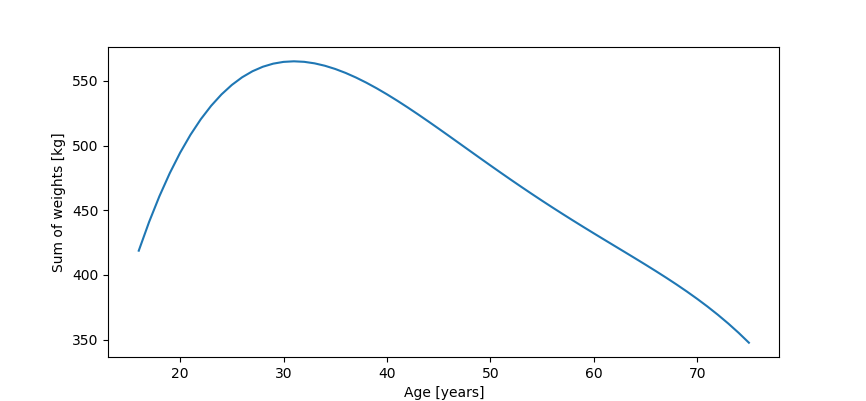

In [145]:
plt.plot(age_sim, y_sim)
plt.ylabel('Sum of weights [kg]')
plt.xlabel('Age [years]')
plt.show()

In [135]:
idx_max = np.argmax(y_sim)
age_sim[idx_max]

31